# Importing Libraries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.config.experimental import get_visible_devices, set_memory_growth
import matplotlib.pyplot as plt

# Initializing GPU

In [2]:
gpus=get_visible_devices("GPU")
for gpu in gpus:
    set_memory_growth(gpu, True)

# Data Preprocessing

## Import data from [Johns Hopkin's University Data Repository](https://github.com/CSSEGISandData/COVID-19/)

In [3]:
confirmed=pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
deaths=pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
recovered=pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

## Extracting global statistics

In [4]:
confirmed_country = confirmed.iloc[:, 1:].groupby(['Country/Region']).sum().iloc[:, 2:].reset_index()
deaths_country = deaths.iloc[:, 1:].groupby(['Country/Region']).sum().iloc[:, 2:].reset_index()
recovered_country = recovered.iloc[:, 1:].groupby(['Country/Region']).sum().iloc[:, 2:].reset_index()

In [5]:
confirmed_country=confirmed_country.append(confirmed_country.iloc[:,1:].sum(axis=0), ignore_index=True)
deaths_country=deaths_country.append(deaths_country.iloc[:,1:].sum(axis=0), ignore_index=True)
recovered_country=recovered_country.append(recovered_country.iloc[:,1:].sum(axis=0), ignore_index=True)

In [6]:
countries=confirmed_country.iloc[:, 0].values
dates=confirmed_country.columns.values[1:]

## Finding daily statistics for all countries

In [7]:
daily_confirmed_country=confirmed_country
for i in range(len(dates)-1, 0, -1):
    daily_confirmed_country[dates[i]]=daily_confirmed_country[dates[i]]-daily_confirmed_country[dates[i-1]]

## Constructing time steps

In [8]:
temp=daily_confirmed_country.iloc[-1,1:].values
step_size=10

In [9]:
x_confirmed=list()
y_confirmed=list()
for i in range(temp.shape[0]-step_size-1):
    x_confirmed.append(temp[i:i+step_size].reshape((step_size, 1)))
    y_confirmed.append(temp[i+step_size+1])
x_confirmed=np.float32(x_confirmed)/temp.max()
y_confirmed=np.float32(y_confirmed).reshape(-1, 1)/temp.max()

In [39]:
print(x_confirmed.shape)
print(x_confirmed.shape)
print(temp.max())

(262, 10, 1)
(262, 10, 1)
439890.0


# Prediction Models

## LSTM

### Model Defination

In [11]:
def model_defn():
    m=Sequential()
    m.add(LSTM(4, return_sequences=True, input_shape=(step_size, 1)))
    m.add(LSTM(8, return_sequences=False))
    m.add(Dense(1, activation='relu'))
    return m

In [12]:
confirmed_model=model_defn()
confirmed_model.compile(optimizer=Adam(learning_rate=0.0001), loss="mae", metrics=["mae", "mse"])

### Model Training

In [13]:
confirmed_history=confirmed_model.fit(x_confirmed, y_confirmed, epochs=20, batch_size=4, shuffle=True, validation_split=0.2)

Epoch 1/20
53/53 [==============================] - 1s 13ms/step - loss: 0.1884 - mae: 0.1884 - mse: 0.0592 - val_loss: 0.4794 - val_mae: 0.4794 - val_mse: 0.2407
Epoch 2/20
53/53 [==============================] - 0s 4ms/step - loss: 0.1560 - mae: 0.1560 - mse: 0.0410 - val_loss: 0.4104 - val_mae: 0.4104 - val_mse: 0.1791
Epoch 3/20
53/53 [==============================] - 0s 4ms/step - loss: 0.1225 - mae: 0.1225 - mse: 0.0266 - val_loss: 0.3376 - val_mae: 0.3376 - val_mse: 0.1243
Epoch 4/20
53/53 [==============================] - 0s 5ms/step - loss: 0.0963 - mae: 0.0963 - mse: 0.0166 - val_loss: 0.2737 - val_mae: 0.2737 - val_mse: 0.0850
Epoch 5/20
53/53 [==============================] - 0s 4ms/step - loss: 0.0840 - mae: 0.0840 - mse: 0.0119 - val_loss: 0.2382 - val_mae: 0.2382 - val_mse: 0.0666
Epoch 6/20
53/53 [==============================] - 0s 4ms/step - loss: 0.0747 - mae: 0.0747 - mse: 0.0091 - val_loss: 0.2048 - val_mae: 0.2048 - val_mse: 0.0515
Epoch 7/20
53/53 [=========

### Performance Visualization

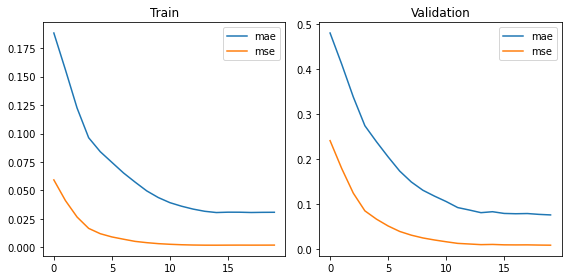

In [14]:
fig=plt.figure(figsize=(8, 4))
ax1=fig.add_subplot(121)
ax1.plot(confirmed_history.history["mae"], label="mae")
ax1.plot(confirmed_history.history["mse"], label="mse")
ax1.set_title("Train")
ax1.legend()
ax2=fig.add_subplot(122)
ax2.plot(confirmed_history.history["val_mae"], label="mae")
ax2.plot(confirmed_history.history["val_mse"], label="mse")
ax2.set_title("Validation")
ax2.legend()
plt.tight_layout()
plt.show()

### Saving the Model

In [41]:
confirmed_model.save("model/world_model.h5")

## GRU

### Model defination

In [24]:
def gru_model_defn():
    m=Sequential()
    m.add(GRU(4, return_sequences=True, input_shape=(step_size, 1)))
    m.add(GRU(4, return_sequences=False))
    m.add(Dense(1, activation='relu'))
    return m

In [27]:
gru_model = gru_model_defn()
gru_model.compile(optimizer = Adam(learning_rate=0.00075), loss = "mse", metrics = ["mse", "mae"])

### Model training

In [28]:
gru_history = gru_model.fit(x_confirmed, y_confirmed, epochs=20, batch_size=8, shuffle=True, validation_split=0.2)

Epoch 1/20
27/27 [==============================] - 1s 20ms/step - loss: 0.0434 - mse: 0.0434 - mae: 0.1578 - val_loss: 0.1201 - val_mse: 0.1201 - val_mae: 0.3312
Epoch 2/20
27/27 [==============================] - 0s 5ms/step - loss: 0.0180 - mse: 0.0180 - mae: 0.1093 - val_loss: 0.0624 - val_mse: 0.0624 - val_mae: 0.2288
Epoch 3/20
27/27 [==============================] - 0s 4ms/step - loss: 0.0145 - mse: 0.0145 - mae: 0.1022 - val_loss: 0.0529 - val_mse: 0.0529 - val_mae: 0.2077
Epoch 4/20
27/27 [==============================] - 0s 5ms/step - loss: 0.0115 - mse: 0.0115 - mae: 0.0891 - val_loss: 0.0445 - val_mse: 0.0445 - val_mae: 0.1868
Epoch 5/20
27/27 [==============================] - 0s 5ms/step - loss: 0.0087 - mse: 0.0087 - mae: 0.0759 - val_loss: 0.0340 - val_mse: 0.0340 - val_mae: 0.1579
Epoch 6/20
27/27 [==============================] - 0s 5ms/step - loss: 0.0064 - mse: 0.0064 - mae: 0.0662 - val_loss: 0.0241 - val_mse: 0.0241 - val_mae: 0.1311
Epoch 7/20
27/27 [=========

### Performance Visualization

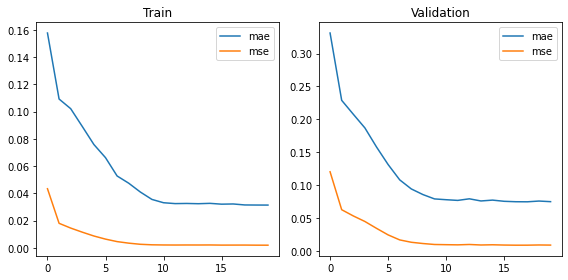

In [29]:
fig=plt.figure(figsize=(8, 4))
ax1=fig.add_subplot(121)
ax1.plot(gru_history.history["mae"], label="mae")
ax1.plot(gru_history.history["mse"], label="mse")
ax1.set_title("Train")
ax1.legend()
ax2=fig.add_subplot(122)
ax2.plot(gru_history.history["val_mae"], label="mae")
ax2.plot(gru_history.history["val_mse"], label="mse")
ax2.set_title("Validation")
ax2.legend()
plt.tight_layout()
plt.show()

### Saving Model

In [42]:
gru_model.save("model/gru_model.h5")

In [40]:
t1=np.float32(daily_confirmed_country.iloc[-1,-10:].values/439890.0)
confirmed_model.predict(np.reshape(t1, (1, -1, 1)))[0][0]

0.7663608